# MNIST (0 vs 1) Self-Organizing Map (SOM) 데모

MNIST 숫자 데이터 중 **0과 1만** 사용해서 SOM을 간단히 학습하고, U-Matrix / Label map으로 분리되는지 확인합니다.

- 데이터: MNIST (28×28)
- 클래스: 0, 1 (2개)
- 입력: 784차원 (옵션: PCA로 축소)

In [3]:
# 필수 임포트 + SOM 모듈 경로 설정
import sys
import numpy as np
import matplotlib.pyplot as plt

# 이 노트북 위치: self-organizing-map/model-test/simple_example
# SOM 구현은 상위 폴더(model-test)의 som.py에 있음
sys.path.append('..')

from som import SelfOrganizingMap

# 재현성
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12

print('Imports OK')

Imports OK


MNIST: (70000, 28, 28) (70000,) labels: [0 1 2 3 4 5 6 7 8 9]
Filtered 0/1: (6000, 28, 28) class balance: [3000 3000]


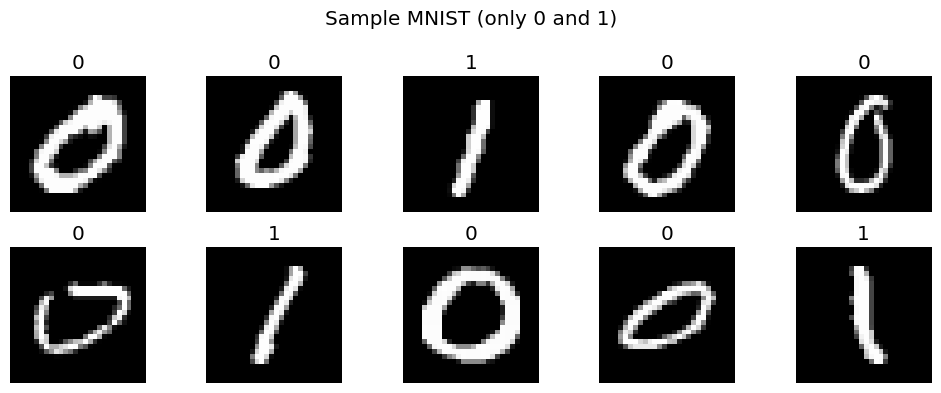

In [4]:
# MNIST 로드 (가능하면 keras 사용, 없으면 OpenML로 fallback)
def load_mnist():
    # 1) tensorflow/keras (보통 가장 간단)
    try:
        from tensorflow.keras.datasets import mnist  # type: ignore
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x = np.concatenate([x_train, x_test], axis=0)
        y = np.concatenate([y_train, y_test], axis=0)
        return x, y
    except Exception as e1:
        print('Keras MNIST load failed:', repr(e1))
        # 2) sklearn OpenML (네트워크 필요할 수 있음)
        try:
            from sklearn.datasets import fetch_openml  # type: ignore
            X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
            x = X.reshape(-1, 28, 28).astype(np.uint8)
            y = y.astype(int)
            return x, y
        except Exception as e2:
            raise RuntimeError(
                'MNIST를 로드할 수 없습니다. '
                'tensorflow(keras) 설치 또는 네트워크가 되는 환경에서 OpenML을 사용하세요.'
            ) from e2

x_all, y_all = load_mnist()
print('MNIST:', x_all.shape, y_all.shape, 'labels:', np.unique(y_all)[:10])

# 0/1만 필터 + 각 클래스 샘플 수 제한
N_PER_CLASS = 3000  # 속도 때문에 일단 2~5천 정도 추천 (원하면 늘려도 됨)

mask01 = (y_all == 0) | (y_all == 1)
x01 = x_all[mask01]
y01 = y_all[mask01]

idx0 = np.where(y01 == 0)[0]
idx1 = np.where(y01 == 1)[0]

rng.shuffle(idx0)
rng.shuffle(idx1)

idx = np.concatenate([idx0[:N_PER_CLASS], idx1[:N_PER_CLASS]])
rng.shuffle(idx)

x01 = x01[idx]
y01 = y01[idx]

print('Filtered 0/1:', x01.shape, 'class balance:', np.bincount(y01))

# 간단 시각화
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x01[i], cmap='gray')
    plt.title(int(y01[i]))
    plt.axis('off')
plt.suptitle('Sample MNIST (only 0 and 1)')
plt.tight_layout()
plt.show()

In [5]:
# SOM 입력 벡터 생성: (N, 28, 28) -> (N, 784) + 정규화
X = x01.reshape(len(x01), -1).astype(np.float32) / 255.0
y = y01.astype(int)

# (선택) per-sample 표준화: 밝기 차이 제거에 도움
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

print('X:', X.shape, 'y:', y.shape, 'y unique:', np.unique(y))

X: (6000, 784) y: (6000,) y unique: [0 1]


In [6]:
# (옵션) PCA로 차원 축소 후 SOM 학습 (784차원 그대로도 가능하지만 PCA가 보통 더 빠르고 안정적)
USE_PCA = True
PCA_DIM = 32  # 16~64 추천

if USE_PCA:
    from sklearn.decomposition import PCA  # type: ignore
    pca = PCA(n_components=PCA_DIM, random_state=SEED)
    X_in = pca.fit_transform(X)
    print(f'PCA: {X.shape[1]} -> {X_in.shape[1]}')
    print(f'Explained variance sum: {pca.explained_variance_ratio_.sum():.4f}')
else:
    X_in = X
    print('PCA skipped')

# SOM 하이퍼파라미터 (처음엔 가볍게)
MAP_SIZE = (20, 20)
SIGMA = max(MAP_SIZE) / 2
LR = 0.5
NUM_ITER = 5000

# 핵심: hex topology로 바꾸면 U-matrix / label map이 육각 타일로 시각화됩니다.
TOPOLOGY = 'hex'   # 'rect' 또는 'hex'
HEX_RADIUS = 1.0   # 육각 타일 크기(그림 스케일)

som = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=X_in.shape[1],
    sigma=SIGMA,
    learning_rate=LR,
    decay_function='exponential',
    topology=TOPOLOGY,
    hex_radius=HEX_RADIUS,
    random_seed=SEED,
 )

print('Training SOM...')
som.train(X_in, num_iterations=NUM_ITER, verbose=True)
print('Done')

print(f'Quantization Error: {som.quantization_error(X_in):.4f}')
print(f'Topographic Error: {som.topographic_error(X_in):.4f}')

PCA: 784 -> 32
Explained variance sum: 0.8490
Training SOM...
Iteration 500/5000 - QE: 15.7151, TE: 0.1495, LR: 0.4525, σ: 7.8717
Iteration 1000/5000 - QE: 14.3640, TE: 0.1505, LR: 0.4094, σ: 6.1934
Iteration 1500/5000 - QE: 13.5344, TE: 0.1215, LR: 0.3705, σ: 4.8729
Iteration 2000/5000 - QE: 12.4740, TE: 0.0865, LR: 0.3352, σ: 3.8340
Iteration 2500/5000 - QE: 11.4682, TE: 0.0628, LR: 0.3033, σ: 3.0166
Iteration 3000/5000 - QE: 10.6242, TE: 0.0597, LR: 0.2745, σ: 2.3734
Iteration 3500/5000 - QE: 10.0650, TE: 0.0652, LR: 0.2483, σ: 1.8674
Iteration 4000/5000 - QE: 9.5557, TE: 0.0588, LR: 0.2247, σ: 1.4692
Iteration 4500/5000 - QE: 9.0845, TE: 0.0742, LR: 0.2033, σ: 1.1560
Iteration 5000/5000 - QE: 8.6781, TE: 0.0900, LR: 0.1840, σ: 0.9095
Done
Quantization Error: 8.6781
Topographic Error: 0.0900


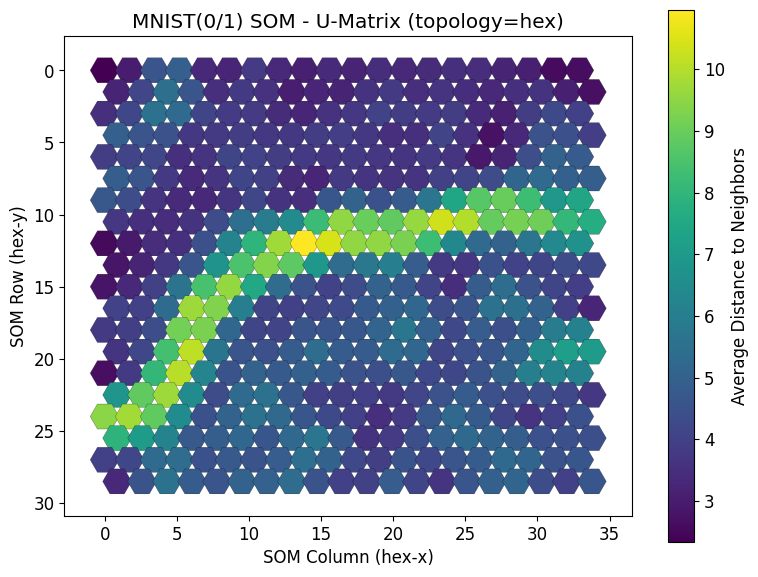

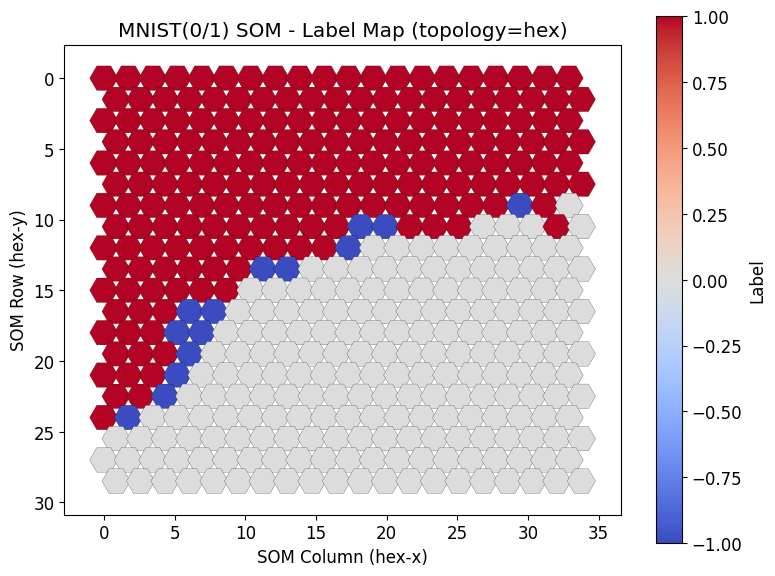

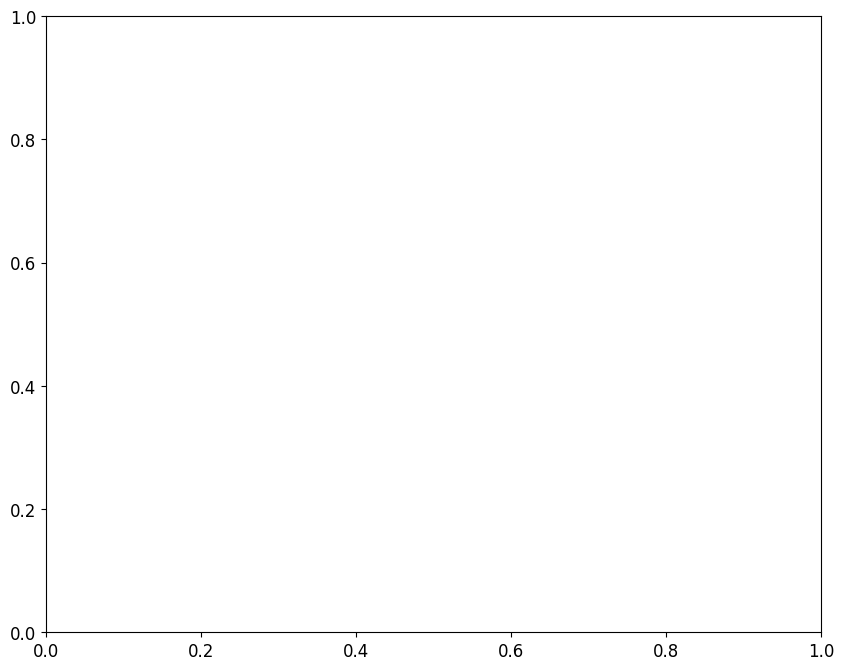

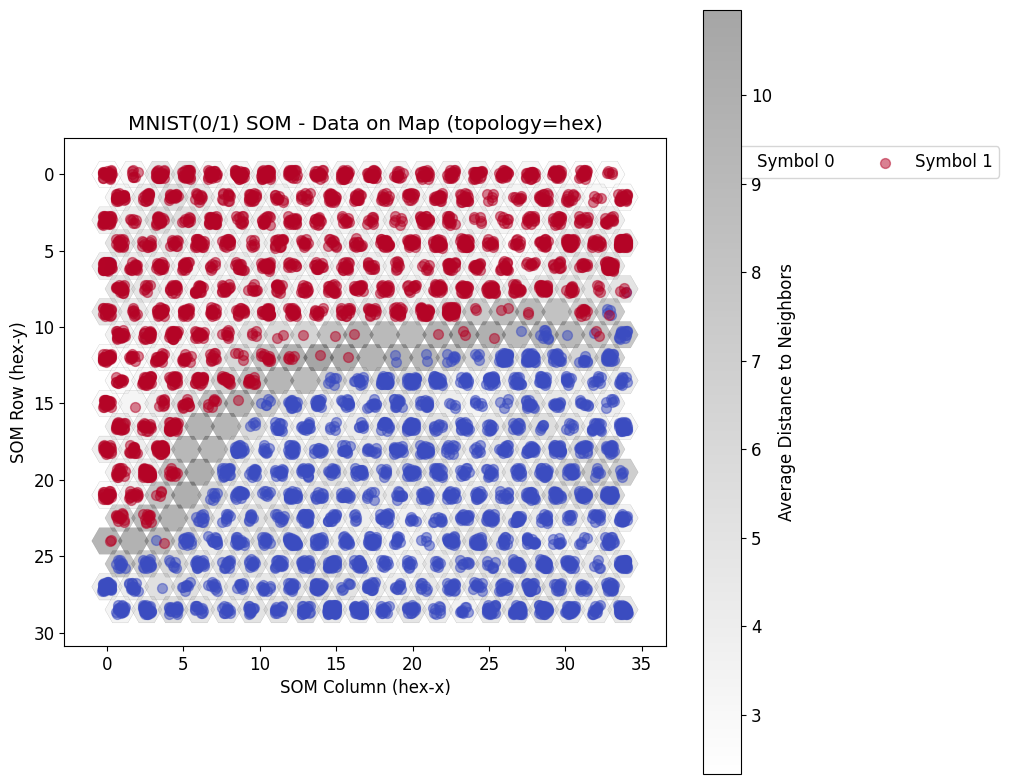

In [7]:
# 결과 시각화: U-matrix + (0/1) 라벨 맵 + 데이터 산점도
fig, ax = som.plot_u_matrix(figsize=(8, 6), cmap='viridis')
plt.title(f'MNIST(0/1) SOM - U-Matrix (topology={TOPOLOGY})')
plt.show()

fig, ax = som.plot_winner_map(X_in, labels=y, figsize=(8, 6), cmap='coolwarm')
plt.title(f'MNIST(0/1) SOM - Label Map (topology={TOPOLOGY})')
plt.show()

# 점들을 맵 위에 찍기(색=0/1)
som.plot_data_on_map(X_in, labels=y, figsize=(10, 8), cmap='coolwarm', alpha=0.5)
plt.title(f'MNIST(0/1) SOM - Data on Map (topology={TOPOLOGY})')
plt.show()

## SOM 프로토타입(가중치) 이미지 타일 시각화 (0 vs 1)

각 뉴런의 가중치 벡터를 28×28 이미지로 되돌려(가능하면 PCA inverse) 한 장의 큰 캔버스로 보여줍니다.

Raw prototype matrix: (400, 32)
Visualizing PCA-inversed prototypes: (400, 784)


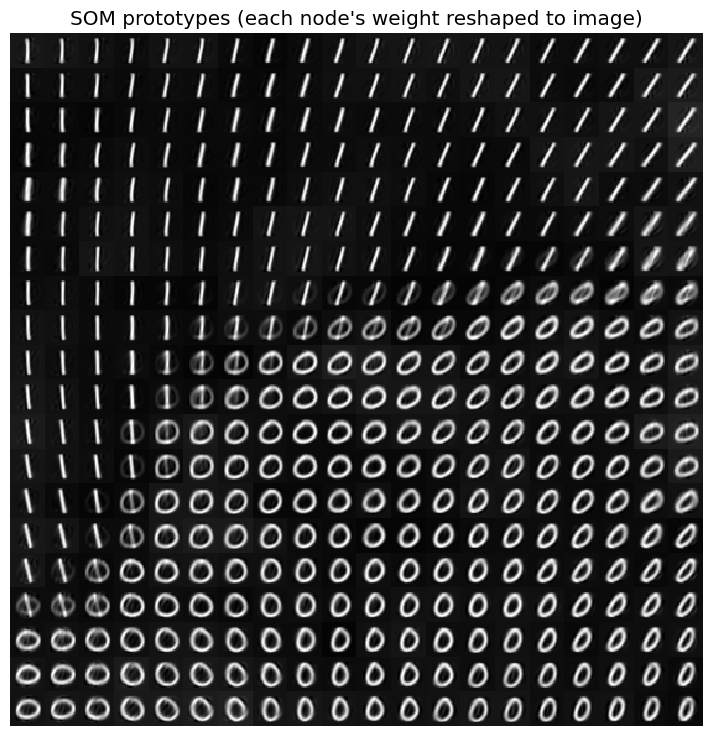

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def show_som_prototypes(W, map_shape, img_shape=(28, 28), normalize_each=True, figsize_scale=0.45):
    """
    W: (n_nodes, n_features) e.g., (rows*cols, 784)
    map_shape: (rows, cols)
    """
    rows, cols = map_shape
    n_nodes, n_feat = W.shape
    assert n_nodes == rows * cols
    assert n_feat == img_shape[0] * img_shape[1]

    tile_h, tile_w = img_shape
    canvas = np.zeros((rows * tile_h, cols * tile_w), dtype=np.float32)

    for idx in range(n_nodes):
        r, c = divmod(idx, cols)
        img = W[idx].reshape(img_shape).astype(np.float32)

        if normalize_each:
            mn, mx = float(img.min()), float(img.max())
            if mx > mn:
                img = (img - mn) / (mx - mn)

        canvas[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w] = img

    fig_w = max(6, int(cols * figsize_scale))
    fig_h = max(6, int(rows * figsize_scale))
    plt.figure(figsize=(fig_w, fig_h))
    plt.imshow(canvas, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title("SOM prototypes (each node's weight reshaped to image)")
    plt.show()

# SOM 가중치 -> (rows*cols, dim)
rows, cols = MAP_SIZE
W = som.weights.reshape(rows * cols, -1)
print('Raw prototype matrix:', W.shape)

# 픽셀(784) 공간으로 복원해서 시각화
if W.shape[1] == 784:
    W_img = W
    print('Visualizing directly in pixel space (784).')
elif 'pca' in globals():
    W_img = pca.inverse_transform(W)
    print('Visualizing PCA-inversed prototypes:', W_img.shape)
else:
    raise RuntimeError(
        f'프로토타입 차원={W.shape[1]}이라 28x28로 바로 시각화 불가. '
        'PCA를 켠 상태에서 학습했는지(그리고 pca 객체가 존재하는지) 확인하세요.'
)

show_som_prototypes(W_img, map_shape=MAP_SIZE, img_shape=(28, 28), normalize_each=True)

## 팁 / 다음 실험

- 더 또렷하게 분리되게 하고 싶으면:
  - `NUM_ITER`를 10000 이상으로 증가
  - `MAP_SIZE`를 24×24 또는 30×30으로 증가
  - `PCA_DIM`을 48~64로 증가
- 0/1 대신 0/1/2…로 늘려서 라벨맵이 어떻게 변하는지도 볼 수 있어요.
- MNIST 로드가 실패하면: `tensorflow` 설치 또는 OpenML 다운로드 가능한 네트워크 환경이 필요합니다.